In [1]:
import numpy as np
import scipy as sp
from scipy.stats import norm
import scipy.stats as stats
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
M=2 #Model 2

In [2]:
#def draw_samp(n,theta,sigma,seed=16):
#    np.random.seed(seed)
#    ind_clus=np.diag(np.sign(np.random.uniform(low=0.0, high=1.0, size=n)-0.5))
#    samp=np.random.normal(ind_clus@np.repeat(theta,n,axis=0),np.repeat(sigma,n,axis=0))
#    return samp

In [3]:
def draw_samp(n,theta,sigma,seed=1):
    np.random.seed(seed)
    samp=np.random.normal(size=(n,np.size(theta)))
    return samp

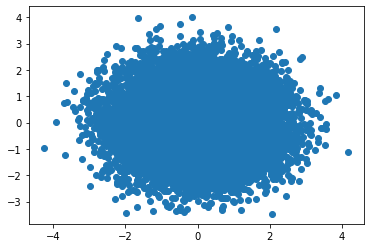

In [4]:
kkk=draw_samp(20000,np.array([[3,2]]),np.array([[1,1]]))
#kkk=draw_samp(2000,np.array([[0,0]]),np.array([[1,1]]))
plt.scatter(kkk[:,0],kkk[:,1])

In [5]:
def normal_pdfs(samp,theta,sigma):

    d=np.size(theta)
    n=np.shape(samp)[0]
    theta=np.repeat(theta,n,axis=0)
    sigma=np.repeat(sigma,n,axis=0)
    log_pdf_pos=np.sum(norm.logpdf(samp,theta,sigma),axis=1)
    log_pdf_neg=np.sum(norm.logpdf(samp,-theta,sigma),axis=1)
    pdf_pos=np.reshape(np.exp(log_pdf_pos),(n,1))
    pdf_neg=np.reshape(np.exp(log_pdf_neg),(n,1))

    
    return pdf_pos, pdf_neg


def L(samp,theta,sigma,pdf_pos,pdf_neg):
    """
    L_value
    theta:mean
    nu: precision
    """
    #samp=draw_samp(100,theta_star,sigma_star)
    d=np.size(theta)
    n=np.shape(samp)[0]
    theta=np.repeat(theta,n,axis=0)
    sigma=np.repeat(sigma,n,axis=0)
    
    L_val=np.mean(np.log(0.5*pdf_pos+0.5*pdf_neg))
    
    return L_val



def dL_theta(samp,theta,sigma,pdf_pos,pdf_neg):
    """
    derivative of theta
    theta:mean
    nu: precision
    """
    #samp=draw_samp(100,theta_star,sigma_star)
    d=np.size(theta)
    n=np.shape(samp)[0]
    theta=np.repeat(theta,n,axis=0)
    sigma=np.repeat(sigma,n,axis=0)
    
    nomi=0.5*pdf_pos*(-(theta-samp)/(sigma**2))+0.5*pdf_neg*(-(theta+samp)/(sigma**2))
    deno1=(0.5*pdf_pos+0.5*pdf_neg)
    #deno2=np.reshape(deno1,(n,1))
    deno=np.repeat(deno1,d,axis=1)
    res=np.mean(nomi/deno,axis=0)
    
    return res

def dL_sigma_theta(samp,theta,sigma,pdf_pos,pdf_neg):
    """
    dL_sigma*dsigma_theta
    theta:mean
    nu: precision
    """
    #samp=draw_samp(100,theta_star,sigma_star)
    d=np.size(theta)
    n=np.shape(samp)[0]
    theta=np.repeat(theta,n,axis=0)
    sigma=np.repeat(sigma,n,axis=0)
    
    nomi_pos=-pdf_pos/sigma+pdf_pos*(samp-theta)**2/(sigma**3)
    nomi_neg=-pdf_neg/sigma+pdf_neg*(samp+theta)**2/(sigma**3)
    nomi=0.5*nomi_pos+0.5*nomi_neg
    deno1=(0.5*pdf_pos+0.5*pdf_neg)
    deno=np.repeat(deno1,d,axis=1)
    
    dsigma_theta=-theta/sigma
    
    res=np.mean(nomi/deno*dsigma_theta,axis=0)
    
    return res




In [6]:
def adaEGD(eps,theta0,theta_star,sigma_star,eta,beta,samp):
    
    theta=theta0
    theta_hat=theta
    
    samp_square_average=np.mean(samp**2,axis=0).reshape(1,np.size(theta0))
    
    sigma=np.sqrt(samp_square_average-theta**2)
    
    DIFF_theta=np.array([])
    DIFF_sigma=np.array([])
    
    pdf_pos,pdf_neg=normal_pdfs(samp,theta,sigma)
    L1=L(samp,theta,sigma,pdf_pos,pdf_neg)
    
    ITER=0
    
    ERROR=np.linalg.norm(theta-theta_star)
    
    
    
    while ERROR>eps and ITER<=1300:
        i=ITER
        ITER += 1
        
        DIFF_theta=np.append(DIFF_theta,np.linalg.norm(theta-theta_star))
        #DIFF_theta=np.append(DIFF_theta,np.linalg.norm(theta-theta_hat))
        DIFF_sigma=np.append(DIFF_sigma,np.linalg.norm(sigma-sigma_star))
        
        
        pdf_pos,pdf_neg=normal_pdfs(samp,theta,sigma)
        DLN_theta=dL_theta(samp,theta,sigma,pdf_pos,pdf_neg)+dL_sigma_theta(samp,theta,sigma,pdf_pos,pdf_neg)
    
        theta=theta+eta/(beta**i)*DLN_theta
        sigma=np.sqrt(samp_square_average-theta**2)
        
        L2=L(samp,theta,sigma,pdf_pos,pdf_neg)
        ERROR=np.linalg.norm(theta-theta_star)
        
        if L2>L1:
            theta_hat=theta
            L1=L2
            
        if ITER%100==0:
            print(ERROR, ITER, np.log(np.size(samp)/d),beta, M)
        
        
    return DIFF_theta, DIFF_sigma,theta_hat,ITER

In [7]:
def main(n_samp, eps_base, theta0, beta, eta, seed):

    d=np.size(theta0)

    samp=draw_samp(n_samp,theta_star,sigma_star,seed)
    eps=eps_base*(n_samp**(-1/4))
    DIFF_adagrad_theta,DIFF_adagrad_sigma,theta_hat,optimal_iter=adaEGD(eps,theta0,theta_star,sigma_star,eta,beta,samp)
    DIFF_GD_theta,DIFF_GD_sigma,theta_hat_GD,optimal_iter_GD=adaEGD(eps,theta0,theta_star,sigma_star,eta,1,samp)
        
    return optimal_iter, optimal_iter_GD

In [8]:
theta_star=np.array([[0,0,0]])
sigma_star=np.array([[1,1,1]])

theta_star=np.array([[0,0]])
sigma_star=np.array([[1,1]])

#theta_star=np.array([[0]])
#sigma_star=np.array([[1]])

In [9]:
seed=1
eps_base=0.3*np.sqrt(2)*np.exp(13.5/4)
#experiment_repeat_times=10
    
theta0=np.array([[0.1,0.1,0.1]]) #initial
theta0=np.array([[0.3,0.3]]) #initial
#theta0=np.array([[0.3]]) #initial


beta=0.995
eta=0.005

In [ ]:
#n_samp=np.array([np.ceil(np.exp(12.5)),np.ceil(np.exp(13)),np.ceil(np.exp(13.5)),np.ceil(np.exp(14)),np.ceil(np.exp(14.5)),np.ceil(np.exp(15))],dtype=int)
#n_samp=np.array([np.ceil(np.exp(10)),np.ceil(np.exp(6)),np.ceil(np.exp(7))],dtype=int)
n_samp=np.array([np.ceil(np.exp(13.7)),np.ceil(np.exp(14)),np.ceil(np.exp(14.3)),np.ceil(np.exp(14.5)),np.ceil(np.exp(14.7)),np.ceil(np.exp(15))],dtype=int)

experiment_repeat_times=np.size(n_samp)

d=np.size(theta0)


temp=Parallel(n_jobs=2*experiment_repeat_times)(delayed(main)(N_samp, eps_base, theta0, beta, eta, seed) for N_samp in n_samp)




In [ ]:
ITER, ITER_GD=zip(*temp)

In [ ]:
gmm_data = {'ITER':ITER,
            'ITER_GD':ITER_GD,
            'theta0':theta0,
            'beta':beta,
            'eta':eta,
            'd':d,
            'theta_star':theta_star,
            'sigma_star':sigma_star,
            'M':M,
            "eps_base":eps_base,
            "experiment_repeat_times":experiment_repeat_times,
            "seed":seed}
Eps_base=int(np.ceil(eps_base))
np.save('./sim_data/M2_iter_fixed_epsbase{}_seed{}_dim{}_repeat{}_eta{}_beta{}_paral'.format(Eps_base,seed,d,experiment_repeat_times,eta,beta),gmm_data)

Text(0, 0.5, 'Iteration')

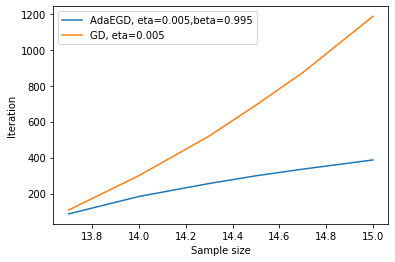

In [16]:
plt.plot(np.log(n_samp), ITER, label='AdaEGD, eta={eta:.3f},beta={beta:.3f}'.format(eta=eta,beta=beta))
plt.plot(np.log(n_samp), ITER_GD, label='GD, eta={eta:.3f}'.format(eta=eta,beta=beta))
plt.legend()
plt.xlabel('Sample size')
plt.ylabel('Iteration')

In [ ]:
stats.linregress(np.log(n_samp[:]),ITER)

In [ ]:
stats.linregress(np.log(n_samp[:]),ITER_GD)